In [ ]:
import pandas as pd
import numpy as np


df = pd.read_csv('/content/combine.csv')
df['valid'] = pd.to_datetime(df['valid'])
df = df.sort_values('valid').reset_index(drop=True)
df['p01m'] = df['p01m'].fillna(0)


df['hour'] = df['valid'].dt.hour
df['dayofweek'] = df['valid'].dt.dayofweek
df['month'] = df['valid'].dt.month
df['year'] = df['valid'].dt.year


In [ ]:
for lag in range(1, 25):
    df[f'lag_{lag}'] = df['p01m'].shift(lag)

df = df.dropna().reset_index(drop=True)


In [ ]:

X = df.drop(columns=['valid', 'station', 'lon', 'lat', 'elevation', 'p01m'])
y = df['p01m']

test_mask = df['year'] >= 2023


X_test = X[test_mask]
y_test = y[test_mask]


X_train = X[~test_mask]
y_train = y[~test_mask]

# Check how many rows are after 2023
print("Test size:", X_test.shape[0])


Test size: 20079


In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Trainmodel
xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)


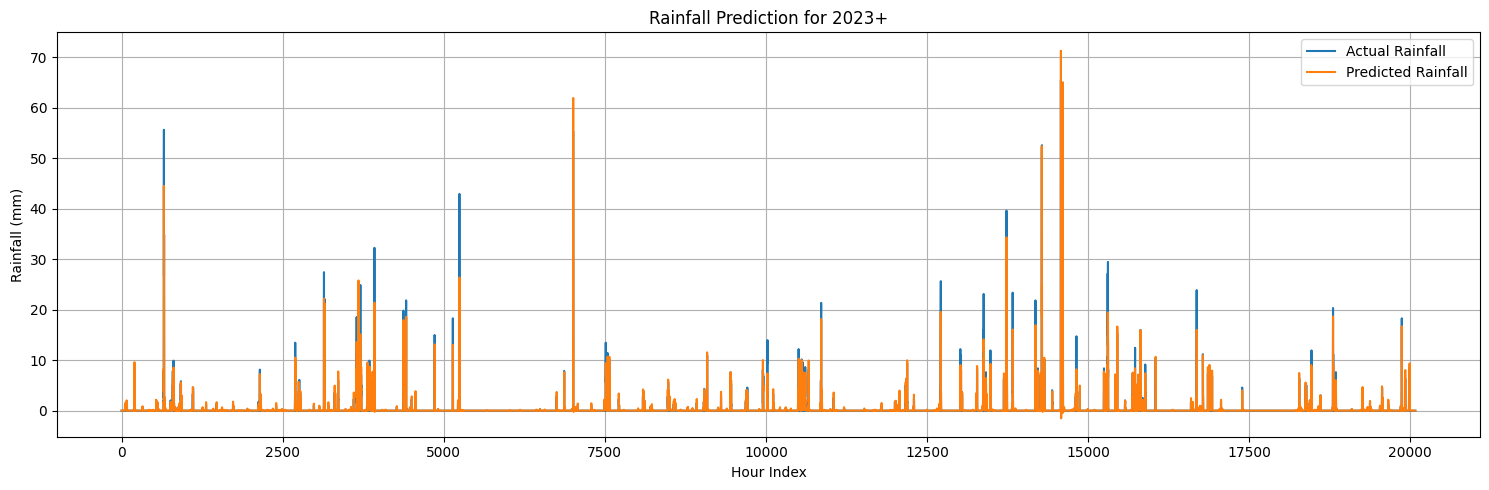

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test.values, label='Actual Rainfall')
plt.plot(y_pred, label='Predicted Rainfall')
plt.title("Rainfall Prediction for 2023+")
plt.xlabel("Hour Index")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 0.2113
RMSE: 1.4785
R² Score: 0.4485


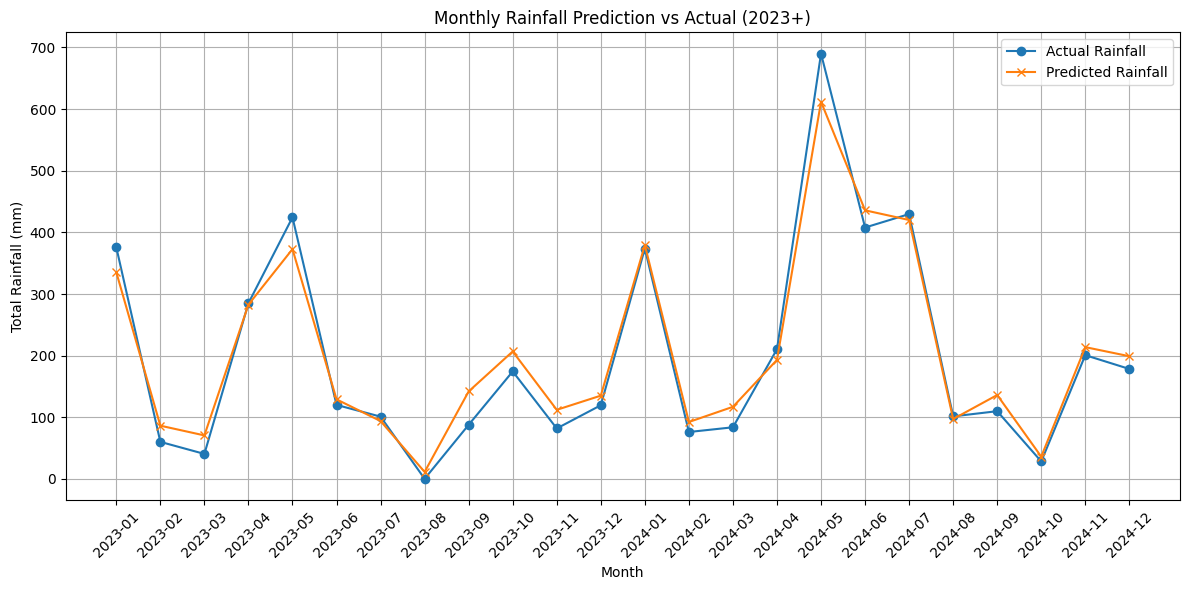

In [ ]:
df_test = df[test_mask].copy().reset_index(drop=True)

df_test['actual'] = y_test.values
df_test['predicted'] = y_pred
df_test['year_month'] = df_test['valid'].dt.to_period('M')

monthly = df_test.groupby('year_month')[['actual', 'predicted']].sum().reset_index()
monthly['year_month'] = monthly['year_month'].astype(str)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly['year_month'], monthly['actual'], marker='o', label='Actual Rainfall')
plt.plot(monthly['year_month'], monthly['predicted'], marker='x', label='Predicted Rainfall')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.title("Monthly Rainfall Prediction vs Actual (2023+)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



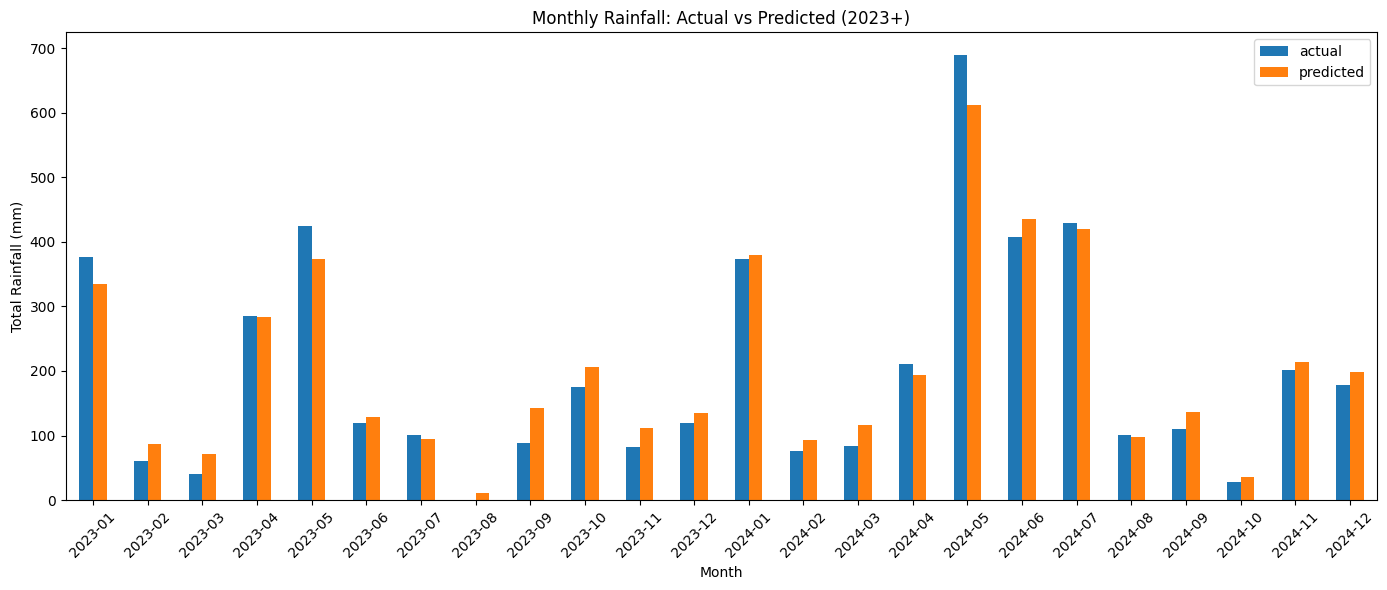

In [ ]:
monthly.plot(
    x='year_month',
    y=['actual', 'predicted'],
    kind='bar',
    figsize=(14, 6),
    title="Monthly Rainfall: Actual vs Predicted (2023+)"
)
plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Save the model to a file
xgb_model.save_model('/content/xgb_rainfall_model.json')
